In [6]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#for live plotting
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

%run lipm_env.ipynb #imports LIPM Env

from py_bullet_env.bullet_solo_env import SoloBulletEnv

In [7]:
class Buffer:
    def __init__(self, buffer_size):
        
        self.buffer_size = buffer_size
        self.buffer = np.zeros((1, 2 + 1 + 1 + 2)) ## should be made variables
        
    def size(self):
        
        return len(self.buffer)
    
    def store(self, state, action, reward, next_state, done):
        ## stores new data in the buffer
        new_data = 9999*np.ones((1, 2 + 1 + 1 + 2))
        new_data[0, 0:2] = state
        new_data[0, 2:4] = [action, reward]
        if not done:
            new_data[0, 4:] = next_state 
        else:
            new_data[0, 4:] = [np.nan, np.nan]
        self.buffer = np.concatenate((self.buffer, np.around(new_data, 2)), axis = 0)
        
        #removes the first element if it is zero.
        if np.all(self.buffer[0] == 0):
            self.buffer = self.buffer[1:]
            
        # removes first element if the desired buffer size is obtained
        elif self.size() > self.buffer_size:
            self.buffer = self.buffer[1:]
            
    def sample(self, batch_size):
        # returns a random mini batch of desired batch size
        return np.asarray(random.sample(list(self.buffer), batch_size))

In [8]:
class NN(nn.Module):
    def __init__(self, inp_size, out_size):
        
        super(NN, self).__init__()
        self.l1 = nn.Linear(inp_size, 2048)
        self.l2 = nn.Linear(2048, 2048)
        self.l3 = nn.Linear(2048, 1024)
        self.l4 = nn.Linear(1024, out_size)
    
    def forward(self, x):
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = self.l4(x)
        return x

In [9]:
class DQStepper:
    def __init__(self, no_actions = 9, lr = 1e-4, gamma = 0.9, use_tarnet = False, trained_model = None):
        
        self.device = torch.device("cpu")
        self.dq_stepper = NN(3, 1).to(self.device) #state+ action -> q_value
        if trained_model:
            self.dq_stepper.load_state_dict(torch.load(trained_model))
            self.dq_stepper.eval()
        self.optimizer = torch.optim.SGD(self.dq_stepper.parameters(), lr)
        self.use_tarnet = use_tarnet
        if self.use_tarnet:
            self.dq_tar_stepper = NN(3, 1).to(self.device)
            self.dq_tar_stepper.load_state_dict(self.dq_stepper.state_dict())
            self.dq_tar_stepper.eval()
        self.gamma = gamma #discount factor
        self.no_actions = no_actions
                
    def predict_action_value(self, x):
        # this function predicts the q_value for different actions and returns action and min q value
        x_in = np.tile([x[0], x[1], 0], (self.no_actions, 1))        
        x_in[:,2] = np.arange(self.no_actions)
        torch_x_in = torch.FloatTensor(x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
        return np.argmin(q_values), q_values[np.argmin(q_values)]
    
    def tar_predict_action_value(self, x):
        # this function uses tar net to predict 
        # the q_value for different actions and returns action and min q value
        x_in = np.tile([x[0], x[1], 0], (self.no_actions, 1))
        x_in[:,2] = np.arange(self.no_actions)
        torch_x_in = torch.FloatTensor(x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_tar_stepper(torch_x_in).detach().numpy()
        return np.argmin(q_values), q_values[np.argmin(q_values)]
    
    def predict_eps_greedy(self, x, eps = 0.1):
        # This function returns prediction based on epsillon greedy algorithm
        if np.random.random() > eps:
            return self.predict_action_value(x)[0]
        else:
            return np.random.randint(self.no_actions)
        
    def optimize(self, mini_batch, tau = 0.001):
        # This function performs one step of back propogation for the given mini_batch data
        x_in = torch.FloatTensor(mini_batch[:,0:3].copy(), device = self.device)
        y_train = torch.FloatTensor(mini_batch[:,3].copy(), device = self.device)
        for i in range(len(mini_batch)):
            if not np.isnan(mini_batch[i,4:]).all():
                if not self.use_tarnet:
                    y_train[i] += self.gamma * self.predict_action_value(mini_batch[i,4:])[1]
                else:
                    y_train[i] += self.gamma * self.tar_predict_action_value(mini_batch[i,4:])[1]

        y_train = y_train.unsqueeze(1).detach() #ensures that gradients are not computed on this
        x_train = self.dq_stepper(x_in)

        loss = F.mse_loss(x_train, y_train)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.use_tarnet:
            for tar_param, param in zip(self.dq_tar_stepper.parameters(), self.dq_stepper.parameters()):
                tar_param.data.copy_(tar_param.data * (1.0 - tau) + param.data * tau)
                
        return loss
    
    def live_plot(self, history, figsize=(7,5), title='history'):
        clear_output(wait=True)
        plt.figure(figsize=figsize)
        for label,data in history.items():
            plt.plot(data, label=label)
        plt.title(title)
        plt.grid(True)
        plt.xlabel('episode')
        plt.ylim(0, 350)
        plt.legend(loc='top right') # the plot evolves to the right
        plt.show();
        
    def predict_q(self, x):
        #for debugging
        # this function predicts the q_value for different actions and returns action and min q value
        x_in = np.tile([x[0], x[1], 0], (self.no_actions, 1))
        x_in[:,2] = np.arange(self.no_actions)
        torch_x_in = torch.FloatTensor(x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
        return q_values

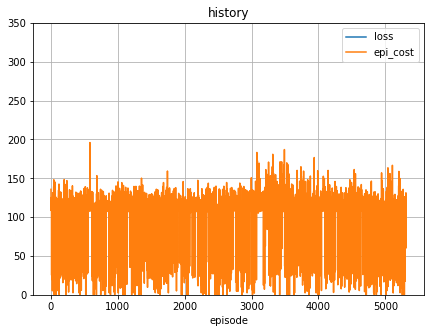

KeyboardInterrupt: 

In [10]:
buffer_size = 10000
buffer = Buffer(buffer_size)

name = "dqs_3"
dqs = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, no_actions=21, trained_model='../../models/dqs_3')
batch_size = 16
epsillon = 0.2

e = 1
no_epi = 10000
no_steps = 10 ## number of steps simulated per episode (pendulum steps)
step_time = 0.1 ## time after which step is taken
env = LipmEnv(0.2, 0.22, [3, 3, 2], no_actions=21)

history = {'loss':[], 'epi_cost':[]}
while e < no_epi:
#     v_init = 8*(np.random.rand() - 0.5)
    v_init = 1.5*(np.random.randint(3) - 1)
    state = env.reset_env([0.0, v_init], no_steps*step_time)
    if e % 500 == 0 and e > 10:
        torch.save(dqs.dq_stepper.state_dict(), "../../models/" + name)
    if buffer.size() == buffer_size:
        history['epi_cost'].append(epi_cost)
        dqs.live_plot(history)
        e += 1
    epi_cost = 0
    for n in range(no_steps):
        action = dqs.predict_eps_greedy(state, epsillon)
        next_state, cost, done = env.step_env(action, step_time)
        buffer.store(state, action, cost, next_state, done)
        state = next_state
        
        if buffer.size() == buffer_size:
            ## optimizing DQN
            loss = dqs.optimize(buffer.sample(batch_size))            
            epi_cost += cost
        if done:
            break
        

In [ ]:
# this block is to load a stepper
dqs = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, trained_model='../../models/dqs_3', no_actions = 21)

In [ ]:
## visualising the q values
q_arr = []
q_arr.append(dqs.predict_q([0.0, 0.0]))
print(q_arr[0])

q_arr.append(dqs.predict_q([0, 1]))

plt.plot(np.arange(0, len(q_arr[0]-1)), q_arr[0])
plt.plot(np.arange(0, len(q_arr[0]-1)), q_arr[1], 'x')
plt.show()

In [ ]:
no_steps = 10 ## number of steps simulated per episode (pendulum steps)
step_time = 0.1 ## time after which step is taken
env = LipmEnv(0.2, 0.22, [2, 2, 4], no_actions=21)

state = env.reset_env([0.0, -1.0], no_steps*step_time)
epi_cost = 0
for n in range(no_steps):
    action, q_value = dqs.predict_action_value(state)
    print(action)
    next_state, cost, done = env.step_env(action, step_time)
    state = next_state
    epi_cost += cost
    if done:
        print(epi_cost)
        break
print("showing simulation...")  
# env.show_episode(5, 1)

In [ ]:
## This block is to test the stepper in simulation with solo
kp = [100, 100, 100]
kd = [1, 1, 5]
kp_com = [0, 0, 100]
kd_com = [5, 5, 30]
kp_ang_com = [300, 300, 300]
kd_ang_com = [100, 100, 100]

step_time = 0.1
ht = 0.2
des_com = [0.2, 0, ht]
des_vel = [0, 0, 0]
x_ori = [0, 0, 0, 1]
x_angvel = [0, 0, 0]


solo_env = SoloBulletEnv(ht, step_time, kp, kd, kp_com, kd_com, kp_ang_com, kd_ang_com)

env = LipmEnv(0.2, 0.22, [2, 2, 0], no_actions=21)
action_space = env.action_space
dqs = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, trained_model='../../models/dqs_3', no_actions=21)
action = [0, 0]

In [ ]:
x, xd, u = solo_env.reset_env()
state_x = [x[0] - u[0], xd[0]]
state_y = [x[1] - u[1], xd[1]]

des_vel = [0.5, 0.0, 0]
solo_env.update_gains(kp, kd, kp_com, [10, 10, 30], [500, 500, 300], kd_ang_com)
for n in range(20):
    action[0] = action_space[dqs.predict_action_value(state_x)[0]] + u[0]
    action[1] = action_space[dqs.predict_action_value(state_y)[0]] + u[1]
    print(state_y, action_space[dqs.predict_action_value(state_y)[0]])
    x, xd, u = solo_env.step_env(action, des_com, des_vel, x_ori, x_angvel)
    state_x = [x[0] - u[0], xd[0]]
    state_y = [x[1] - u[1], xd[1]]